Model Test

In [2]:
import numpy as np
import pandas as pd

df1 = pd.read_csv('merged-df.csv')

df1.columns

Index(['transaction_id', 'date', 'user_id', 'card_id', 'amount', 'use_chip',
       'merchant_id', 'merchant_city', 'merchant_state', 'zip', 'mcc',
       'description', 'category', 'user_current_age', 'user_retirement_age',
       'user_birth_year', 'user_birth_month', 'user_gender', 'user_address',
       'user_latitude', 'user_longitude', 'user_per_capita_income',
       'user_yearly_income', 'user_total_debt', 'user_credit_score',
       'user_num_credit_cards', 'card_card_brand', 'card_card_type',
       'card_has_chip', 'card_cvv', 'card_expires', 'card_num_cards_issued',
       'card_credit_limit', 'card_acct_open_date',
       'card_year_pin_last_changed', 'card_card_on_dark_web'],
      dtype='object')

In [3]:
df2 = pd.read_csv('clustering_df.csv' )
df2.columns

Index(['user_id', 'Cluster'], dtype='object')

In [4]:
# Keep only necessary columns
df1 = df1[['date', 'user_id', 'amount']]
df2 = df2[['user_id', 'Cluster']]


df = df1.merge(df2, on='user_id', how='left')


In [5]:
df['month'] = pd.to_datetime(df['date']).dt.to_period('M')
monthly_df = df.groupby(['month', 'Cluster'])['amount'].sum().reset_index()
monthly_df['month'] = monthly_df['month'].dt.to_timestamp()

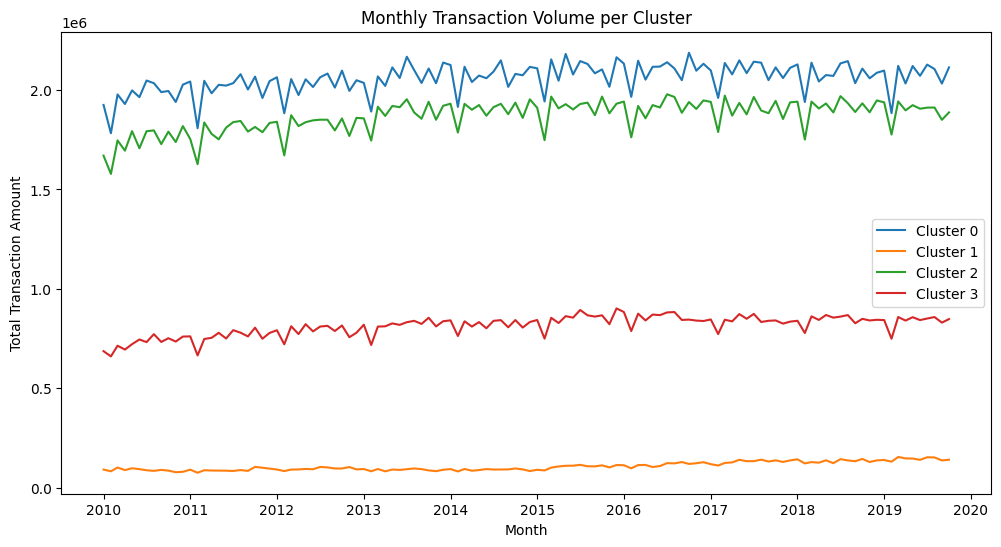

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for cluster in monthly_df['Cluster'].unique():
    temp = monthly_df[monthly_df['Cluster'] == cluster]
    plt.plot(temp['month'], temp['amount'], label=f'Cluster {cluster}')

plt.title('Monthly Transaction Volume per Cluster')
plt.xlabel('Month')
plt.ylabel('Total Transaction Amount')
plt.legend()
plt.show()

For the above graph, we can see there is no strong trend, but obviously, there is strong indicator of seasonality. Let's try to decompose the seasonality

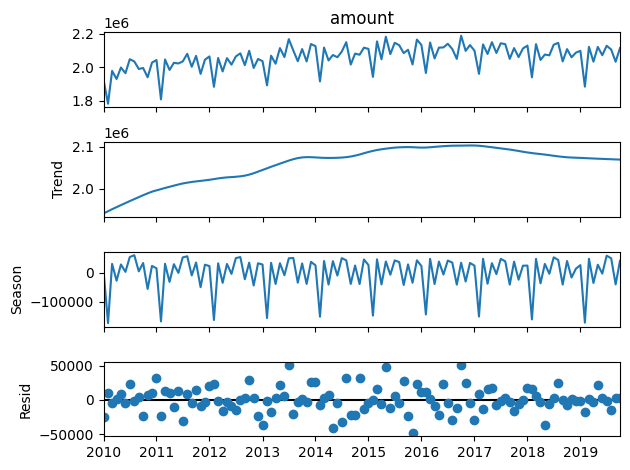

In [7]:
from statsmodels.tsa.seasonal import STL

cluster_id = 0
ts = monthly_df[monthly_df['Cluster'] == cluster_id].set_index('month')['amount']

stl = STL(ts, period=12)
res = stl.fit()
res.plot()
plt.show()

In [8]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(ts)
print('ADF:', result[0])
print('p-value:', result[1])

# No stationarity detected

ADF: -3.5822748223690204
p-value: 0.006109078205214078


In [9]:
# Let's try a simple model with cluster 0
train = ts.iloc[:-12]
test  = ts.iloc[-12:] # Not train on last year's data and use it at test case
print(train.tail(3))
print(test)

month
2018-08-01    2145740.53
2018-09-01    2034794.69
2018-10-01    2108280.89
Name: amount, dtype: float64
month
2018-11-01    2059416.04
2018-12-01    2087177.94
2019-01-01    2098251.94
2019-02-01    1884352.59
2019-03-01    2121947.38
2019-04-01    2033355.17
2019-05-01    2121233.22
2019-06-01    2071898.69
2019-07-01    2128351.78
2019-08-01    2105892.51
2019-09-01    2032906.04
2019-10-01    2114400.61
Name: amount, dtype: float64


In [10]:
from pmdarima import auto_arima

model = auto_arima(train,seasonal=True,m=12,stepwise=True,trace=True,suppress_warnings=True,
    max_p=3, max_q=3,max_P=2, max_Q=2,
    d=None, D=None, information_criterion='aic')

print(model.summary())


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2716.580, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2694.542, Time=0.05 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2703.275, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2714.617, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=2706.577, Time=0.01 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=2688.081, Time=0.11 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=2686.636, Time=0.23 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=2686.105, Time=0.05 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=2696.961, Time=0.03 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=2686.756, Time=0.18 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=2691.068, Time=0.07 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=2694.838, Time=0.05 sec
 ARIMA(2,1,0)(1,0,1)[12] inte

In [11]:
n_periods = len(test)
forecast, conf_int = model.predict(n_periods=n_periods, return_conf_int=True)

pred_df = pd.DataFrame({'Forecast': forecast}, index=test.index)

print(pred_df)

                Forecast
month                   
2018-11-01  2.079711e+06
2018-12-01  2.100740e+06
2019-01-01  2.111818e+06
2019-02-01  2.055903e+06
2019-03-01  2.118291e+06
2019-04-01  2.091716e+06
2019-05-01  2.112145e+06
2019-06-01  2.101564e+06
2019-07-01  2.119382e+06
2019-08-01  2.118867e+06
2019-09-01  2.090737e+06
2019-10-01  2.114694e+06


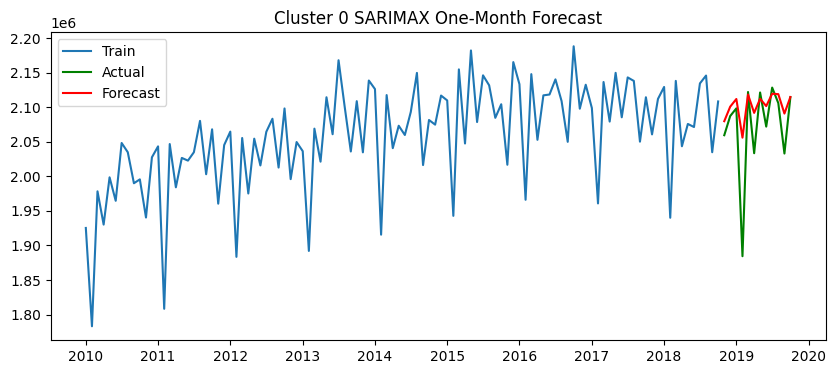

In [12]:
plt.figure(figsize=(10,4))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Actual', color='green')
plt.plot(pred_df.index, pred_df['Forecast'], label='Forecast', color='red')
plt.title(f'Cluster 0 SARIMAX One-Month Forecast')
plt.legend()
plt.show()


In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(test, pred_df['Forecast'])
rmse = np.sqrt(mean_squared_error(test, pred_df['Forecast']))
mape = np.mean(np.abs((test - pred_df['Forecast']) / test)) * 100
print(f'MAE: {mae:.2f},  RMSE: {rmse:.2f}, MAPE: {mape:.2f}%')

MAE: 33317.71,  RMSE: 56409.69, MAPE: 1.68%
